# Automated ecDNA Counting Pipeline: A Step-by-Step Tutorial

## Introduction

Extrachromosomal circular DNA (ecDNA) is increasingly recognized as a critical driver in cancer genomics, contributing to oncogene amplification, intratumoral heterogeneity, and therapy resistance [1]. These circular DNA elements arise from genomic instability in cancer cells, often through mechanisms like chromothripsis and aberrant DNA repair [2]. Unlike chromosomal DNA, ecDNAs lack centromeres, enabling rapid amplification and adaptability, which are linked to tumor progression, drug resistance, and poor prognosis in cancers such as glioblastoma and neuroblastoma [3].

Fluorescence in situ hybridization (FISH) imaging remains the gold standard for ecDNA detection, visualizing fluorescent probes (e.g., HER2, MYC) that highlight these structures [4]. However, manually counting ecDNAs across thousands of images is labor-intensive and impractical for large-scale studies. Existing automated tools like MIA [5] attempt to address this but suffer from high false-negative rates (missing ecDNAs) and false positives (detecting pseudo-ecDNAs), limiting their reliability.

## Pipeline Development and Challenges

EcDNAs are small, circular DNA fragments that amplify oncogenes in cancer cells, and their accurate abundance in FISH images is essential for understanding tumor biology. The absence of annotated ground truth for individual ecDNAs posed a significant challenge, as it prevented the use of standard object detection frameworks requiring precise coordinates. Instead, only aggregate counts per image were available, alongside MIA predictions that marked potential ecDNA locations. Initial attempts to align these predictions with ground truth via pixel-to-pixel comparisons revealed limitations rooted in biological and imaging variability. EcDNAs exhibit diverse sizes—ranging from submicron to a few microns—and variable probe intensities (e.g., MYC or HER2), while FISH images differ widely in contrast and brightness due to staining and imaging conditions. These factors rendered pixel-based metrics, such as intensity thresholds or direct overlap, unreliable for consistent ecDNA identification.

To overcome this, a custom pipeline was developed to enhance and detect ecDNAs by leveraging their distinct visual properties in DAPI (grayscale) and RGB (probe-labeled) FISH images. The approach shifted away from pixel-matching toward a feature-based strategy that amplifies small, bright ecDNA spots while suppressing larger structures like chromosomes. This pipeline integrates image processing techniques ensuring robustness across heterogeneous image conditions. This pipeline enhances image contrast, distinguishes ecDNAs from chromosomes using size and color, and provides counting. This tutorial demonstrates the pipeline step-by-step using five sample images with inline visualizations to illustrate each stage.

**References**  
[1] Turner, K. M. et al. *Nature* (2017). [DOI: 10.1038/nature21356]()   
[2] Koche, R. P. et al. *Cell* (2020). [DOI: 10.1016/j.cell.2020.03.009]()   
[3] Wu, S. et al. *Nature Genetics* (2021). [DOI: 10.1038/s41588-021-00806-2]()   
[4] Nathanson, D. A. et al. *Science* (2014). [DOI: 10.1126/science.1254257]()   
[5] MIA Tool: Li, Y. et al. *Frontiers in Pharmacology* (2024). [DOI: 10.3389/fphar.2024.1516621]()   

---

## Pipeline Overview
- **Inputs**: RGB FISH images, corresponding DAPI images (region of interest, ROI), and MIA-predicted masks.
This pipeline processes FISH images to count ecDNA, leveraging RGB (probe-labeled) and DAPI (grayscale) images. It requires four directories:
1. **RGB Images**: Original FISH images with HER2 (red) and MYC (green) probes.
2. **DAPI Images**: Grayscale images with manually defined regions of interest (ROI) by experts, isolating target cells.
3. **MIA Predictions**: Masks from the MIA algorithm identifying predicted ecDNA locations.
4. **Output Folder**: Stores processed images, counts (CSV), and object data (JSON).
- **Outputs**: Annotated images, ecDNA counts, and validation metrics.

---

### Workflow
1. **Preprocessing**: Mask RGB images with DAPI ROIs to focus on target cells.
2. **Enhancement**: Apply image processing (Top-Hat, CLAHE, sharpening, sigmoid) to highlight ecDNA in DAPI images.
3. **Detection**: Identify ecDNA spots using connected components analysis.
4. **Merging**: Combine nearby detections to avoid over-counting fragmented ecDNA.
5. **Classification**: Use RGB color (HSV space) to distinguish ecDNA (colored) from chromosomes (white).
6. **Visualization**: Overlay detections on grayscale and RGB images for verification.
7. **Validation**: Compare results with MIA predictions using TP, FP, FN metrics.

---

## Setup and Dependencies

### Environment
This pipeline requires Python 3.9+ and the following libraries:

- `OpenCV: 4.11.0.86`       (OpenCV for image processing)
- `NumPy: 1.26.0 `       (numerical operations)
- `Matplotlib: 3.8.4`    (visualizations)
- `json: 2.0.9`
- `csv: 2.0.9`
- `math: 2.0.9`

Install them via:

pip install opencv-python numpy matplotlib scipy

In [3]:
# Import libraries 
import cv2  # OpenCV for image processing
import numpy as np# Numerical operations
import matplotlib
import matplotlib.pyplot as plt  # Inline plotting
import json  # For saving object data
import csv  # For metrics output
import math  # For distance calculations
import os

# Define Output Folder to save images
output_folder = r"/proj/brunk_ecdna_cv_project/Poorya/FACS-FISH_redistribution_NCIH2170/version_2_Acc_87/1_tutorial/sample_data/output" 

# Define a utility function to display images inline
def show_image(img, title='', cmap=None, n=''):
    """
    Display an image inline using matplotlib.
    
    Parameters:
        img (numpy.ndarray): Image array (RGB or grayscale).
        title (str): Figure title.
        cmap (str): Colormap for grayscale images (e.g., 'gray').
    """
    plt.figure(figsize=(10, 8))  
    if len(img.shape) == 2:  # Grayscale image
        plt.imshow(img, cmap=cmap if cmap else 'gray')
    else:  # RGB image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(title, fontsize=12)  
    plt.axis('off')  
    cv2.imwrite(os.path.join(output_folder, f'{n}_{title}.tif'), img)
    plt.show()

print("Environment setup complete.")

Environment setup complete.


## Data Preparation

The pipeline processes three image types:
1. **RGB Images**: FISH images with fluorescent probes (e.g., red for HER2, green for MYC).
2. **DAPI Images**: Grayscale images highlighting nuclei and ecDNAs, with ROIs manually defined by experts.
3. **MIA Masks**: Binary images from MIA predictions for validation.

For this tutorial, we use five sample images stored in `sample_data/`. These represent typical cases to demonstrate the pipeline’s functionality.

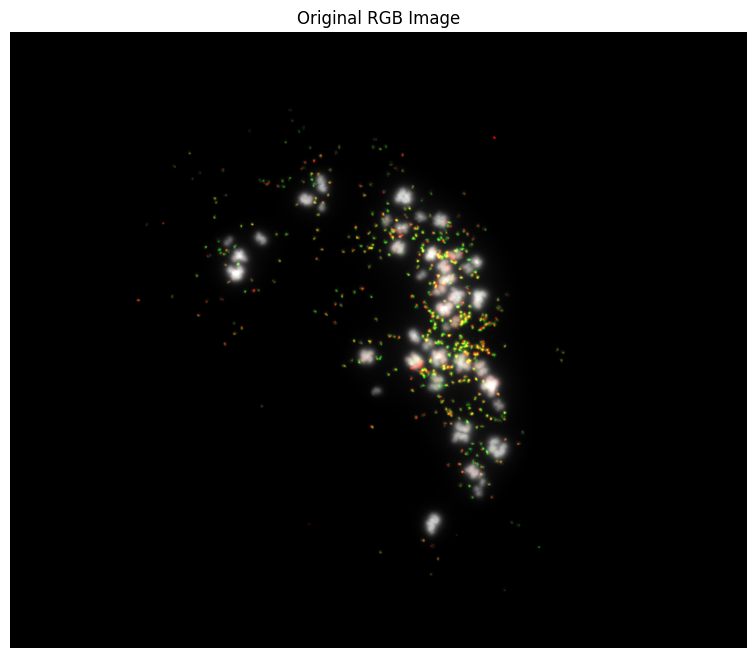

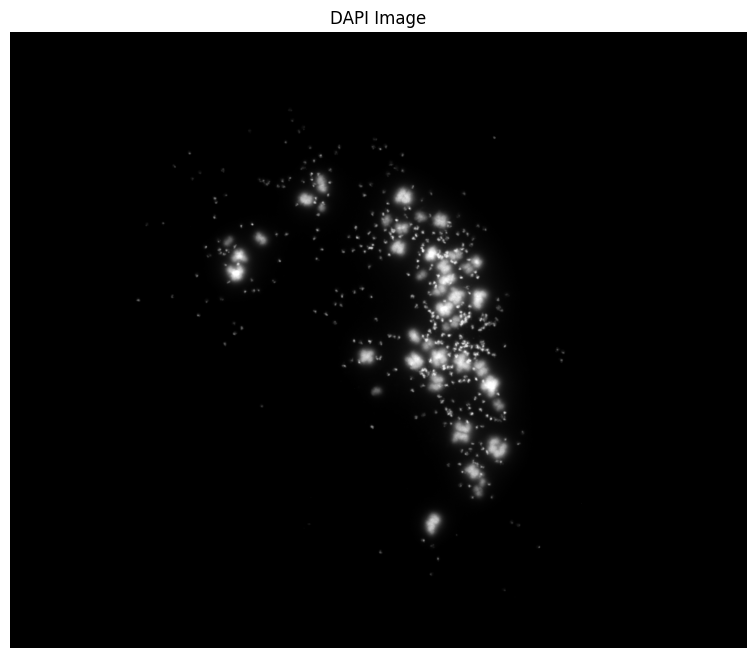

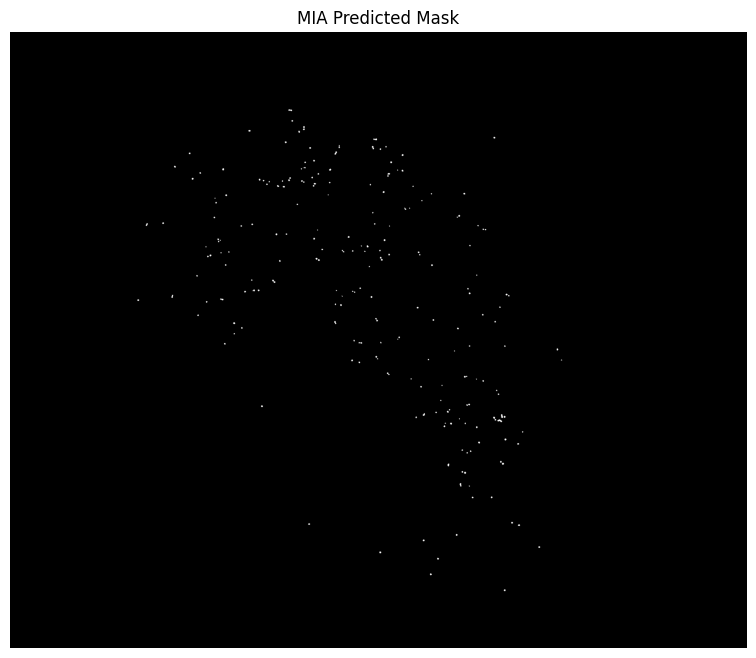

In [4]:
# Define paths to sample images (update these paths based on your local setup)
data_dir = r"/proj/brunk_ecdna_cv_project/Poorya/FACS-FISH_redistribution_NCIH2170/version_2_Acc_87/1_tutorial/sample_data"
#  choose a sample from 1 to 5 and just change the digit in these three directions
sample_rgb = f'{data_dir}//rgb//sample1_Merge.tif'  
sample_dapi = f'{data_dir}//dapi//sample1_DAPI.tif'
sample_mia = f'{data_dir}//Mia//sample1_MIA.tif'

# Load images
rgb_img = cv2.imread(sample_rgb, cv2.IMREAD_COLOR)  ## Load RGB image in BGR format
dapi_img = cv2.imread(sample_dapi, cv2.IMREAD_GRAYSCALE)  # Load DAPI as grayscale
mia_img = cv2.imread(sample_mia, cv2.IMREAD_GRAYSCALE)  # Load MIA mask as grayscale

# Verify loading
if rgb_img is None or dapi_img is None or mia_img is None:
    raise FileNotFoundError("One or more sample images failed to load. Check paths.")

# Display raw images
show_image(rgb_img, 'Original RGB Image', n='1a')
show_image(dapi_img, 'DAPI Image', cmap='gray', n='1b')
show_image(mia_img, 'MIA Predicted Mask', cmap='gray', n='1c')

## Step 1: Mask RGB with DAPI

### Explanation
- RGB images contain ecDNA signals (red/green from HER2/MYC probes) and chromosomes (white). 
- DAPI images, pre-segmented by experts, mark the nucleus ROI in grayscale. 

### Logic
- We apply the DAPI image as a mask to the RGB image to isolate the region of interest (ROI). 
- Pixels in the RGB image are set to black where the DAPI image is black, removing irrelevant areas (e.g., debris, background).

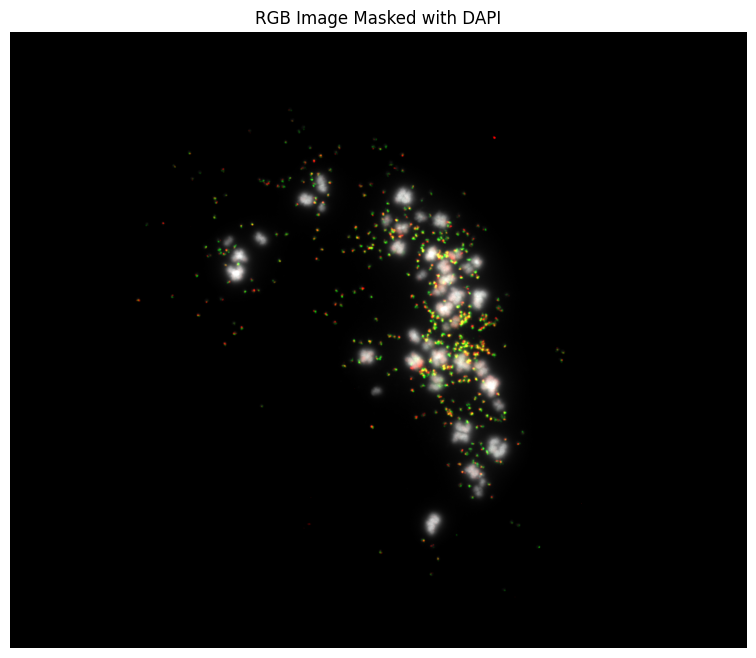

In [6]:
def msk_rgb_dapi(rgb_img, dapi_img):
    """
    Mask RGB image using DAPI to define ROI.
    
    Parameters:
        rgb_img (numpy.ndarray): Input RGB image (BGR format).
        dapi_img (numpy.ndarray): Grayscale DAPI image.
    
    Returns:
        numpy.ndarray: Masked RGB image.
    """
    # Ensure DAPI is grayscale
    if len(dapi_img.shape) != 2:
        dapi_gray = cv2.cvtColor(dapi_img, cv2.COLOR_BGR2GRAY)
    else:
        dapi_gray = dapi_img
    
    # Create binary mask where DAPI is black (value 0)
    mask = (dapi_gray == 0)
    
    # Copy RGB image and apply mask
    rgb_masked = rgb_img.copy()
    rgb_masked[mask] = 0  # Set masked pixels to black
    
    return rgb_masked

# Apply masking
masked_rgb = msk_rgb_dapi(rgb_img, dapi_img)

# Visualize result
show_image(masked_rgb, 'RGB Image Masked with DAPI', n='2')



### Step 2: Image Enhancement

To detect ecDNAs, we enhance the DAPI image. ecDNAs appear as small, bright, circular clusters due to fluorescent probes, while chromosomes are larger and less bright. We apply:
- **Top-Hat Transformation**: Removes large structures (chromosomes). 
- **Sharpening**: Increases edge definition.
- **CLAHE**: Enhances contrast of remaining spots.
- **Sigmoid Adjustment**: Applies a threshold to binarize ecDNAs against the background.

Each enhancement step is visualized to show its effect. Parameters (e.g., kernel_size=20) were tuned to balance ecDNA detection and chromosome removal, as detailed in a separate hyperparameter tuning notebook

### **1. top_hat_enhncmnt()**

This function applies a morphological top-hat transform using OpenCV to enhance small, bright objects (ecDNAs) relative to larger structures (chromosomes).

#### **Why Top-Hat?**
Top-hat transform subtracts morphologically opened images from the original image, isolating small bright spots. Large structures, such as chromosomes, are reduced or removed, enhancing ecDNAs visibility.

#### **Parameters:**

- **`kernel_size:`** Adjusts the size of the structuring element (cv2.getStructuringElement()). Larger values remove bigger structures.

- **`chrom_kernel_size:`** Used for separately identifying chromosomes to soften their intensity, preserving small ecDNAs close to chromosomes.

- **`dampening_factor:`** Multiplier (0-1) to soften intensities of large structures without complete removal.

### **Parameter Tuning:**
 
The pipeline’s image processing steps—Top-Hat transformation, sharpening, contrast-limited adaptive histogram equalization (CLAHE), and sigmoid adjustment—rely on parameters that were initially tuned manually. This process involved systematically adjusting each parameter, one function at a time, to identify ranges that optimized ecDNA visibility. In RGB FISH images, ecDNAs appear colorful due to MYC or ERBB2 (HER2) probes, distinguishing them from the predominantly white chromosomes. In DAPI images, ecDNAs manifest as small, bright, circular objects scattered around cells, often near chromosomes. The underlying logic was to enhance these small clusters of bright pixels while darkening larger structures like chromosomes, facilitating subsequent detection via connected component analysis.

Manual tuning explored a wide parameter space, iteratively refining values to maximize the contrast between ecDNAs and background elements. For example, the Top-Hat transformation used a small kernel to isolate ecDNAs and a larger one to estimate and subtract chromosomal backgrounds. This trial-and-error approach was guided by visual inspection, aiming to make ecDNAs stand out to the human eye as distinct, bright spots against a darker field. After establishing a visually effective parameter set, Bayesian hyperparameter optimization was applied to further refine them. This method minimized the median absolute error between the pipeline’s ecDNA counts and the ground truth totals, using a probabilistic model to explore the parameter space efficiently. The details of this optimization process, including algorithm choice and results, are provided in a separate supplementary notebook.

Interestingly, the optimized parameters sometimes produced images where ecDNAs were less visually distinct to human observers, yet they improved the pipeline’s counting accuracy. This trade-off highlights a divergence between human perception and computational precision, with the final parameters balancing both objectives. The enhancement process consistently aimed to amplify small, bright ecDNA regions while suppressing larger, dimmer structures, ensuring reliable detection across varied image conditions.

**best_params** 

-    `'kernel_size': 10.83, ` Size of the structuring element for top-hat filtering
-    `'clip_limit': 3.95,    `Contrast limit for CLAHE
-    `'tile_grid_size': 21.71,`Tile size for CLAHE grid
-    `'strength': 4.666, `Sharpening strength
-    `'cutoff': 68.44, ` Sigmoid cutoff value
-    `'gain': 23.14,  ` Sigmoid gain factor
-    `'chrom_kernel_size': 168.9,`  Kernel size for chromosome estimation in top-hat
-    `'dampening_factor': 0.3346,`Intensity dampening factor for chromosome regions
-    `'merge_distance': 8.013, ` Distance threshold for merging close objects
-    `'min_area': 4.133, ` Minimum area for detected objects
-    `'max_area': 619.6,` Maximum area for detected objects
-    `'white_value_threshold': 179.5,`  Brightness threshold for chromosome classification
-    `'white_saturation_threshold': 63.32`  Saturation threshold for chromosome classification


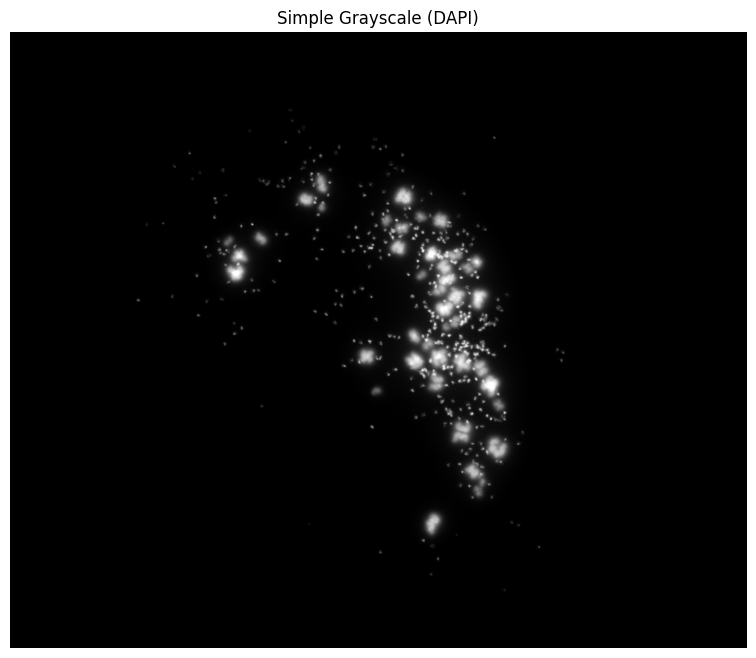

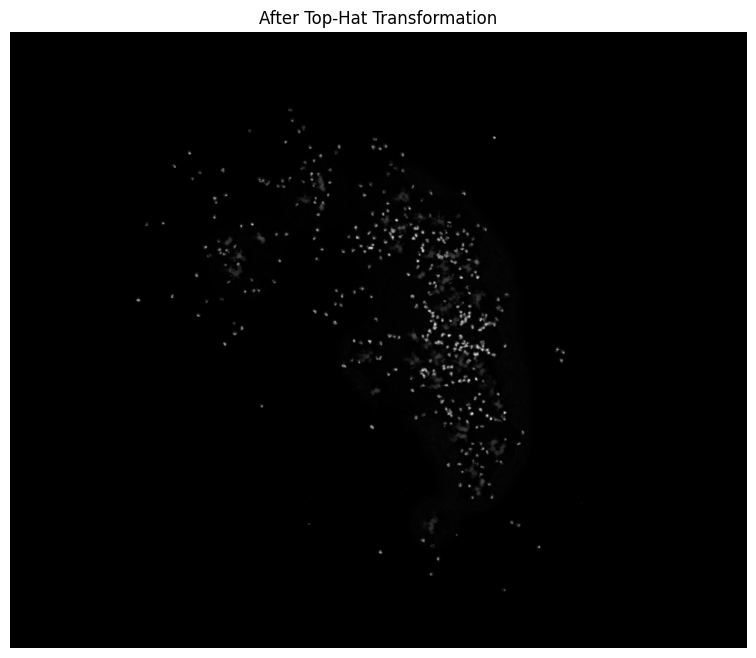

In [10]:
def top_hat_enhncmnt(gray, kernel_size=20, chrom_kernel_size=200, dampn_f=0.5):
    """
    Apply top-hat enhancement and then softly dampen large structures (e.g., chromosomes)
    to preserve nearby small ecDNA spots.
    
    Parameters:
        gray (numpy.ndarray): Grayscale image.
        kernel_size (int): Kernel size for the top-hat transformation.
        chrom_kernel_size (int): Larger kernel size to estimate large structures.
        dampening_factor (float): Factor to dampen intensity in large structure regions (0 < factor < 1).
        
    Returns:
        numpy.ndarray: Enhanced image with large structures softly suppressed.
    
    Explanation:
        - Morphological opening removes features smaller than kernel_size, leaving a background estimate.
        - Subtraction highlights small features. Closing with a larger kernel identifies chromosomes,
          which are softly dampened using Otsu thresholding to preserve nearby ecDNAs.
    """
    
    # Step 1: Standard top-hat transformation
    step1a = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(kernel_size), int(kernel_size)))
    step1b = cv2.morphologyEx(gray, cv2.MORPH_OPEN, step1a)
    top_hat = cv2.subtract(gray, step1b)
    top_hat_norm = cv2.normalize(top_hat, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Step 2: Estimate large structures (chromosomes) using morphological closing
    chrom = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(chrom_kernel_size), int(chrom_kernel_size)))
    chrom = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, chrom)
    
    # Step 3: Create a mask for the chromosomes.
    # Using Otsu thresholding to determine regions corresponding to the chromosomes.
    _, chrom_mask = cv2.threshold(chrom, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step 4: Softly dampen intensity in the chromosome regions in the top-hat image.
    top_hat2 = top_hat_norm.astype(np.float32)
    
    # Multiply the regions in the mask by the dampening factor
    top_hat2[chrom_mask == 255] *= dampn_f
    
    # Clip the values and convert back to uint8
    top_hat2 = np.clip(top_hat2, 0, 255).astype(np.uint8)
    
    return top_hat2


# Enhancement pipeline step 1
simple_gray = dapi_img.copy()  # Starting grayscale
step1 = top_hat_enhncmnt(simple_gray)

# Visualize enhancement step 1
show_image(simple_gray, 'Simple Grayscale (DAPI)', cmap='gray', n='3a')
show_image(step1, 'After Top-Hat Transformation', cmap='gray', n='3b')

### **2. sharp_gray()**

This function applies a sharpening filter through convolution (cv2.filter2D) using a sharpening kernel to emphasize edges and make ecDNA spots clearer.

### **Why Sharpening?**
Enhances boundaries of ecDNAs making them more distinct from the background.

### **Parameters:**

- **`strength:`** Controls sharpening intensity; high values enhance edges but might introduce noise if excessive

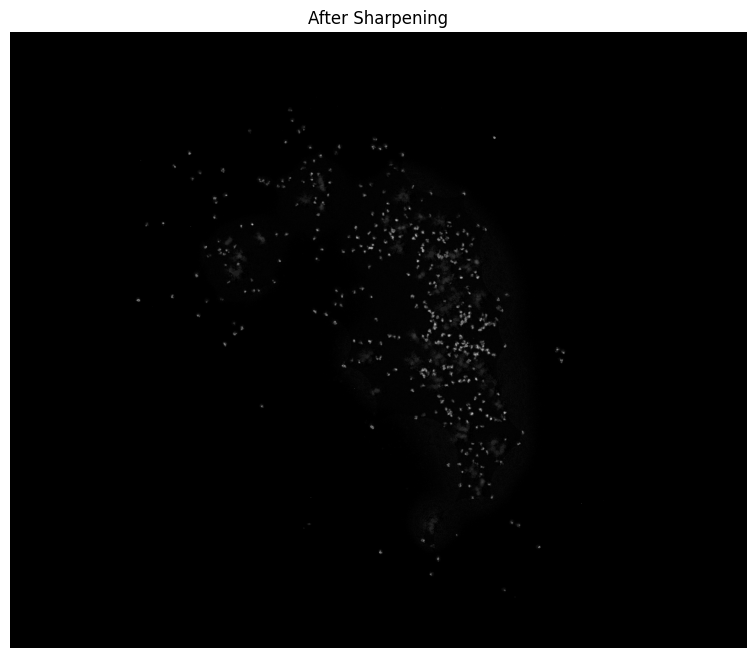

In [12]:
def sharp_gray(gray, strength=7):
    """
    Sharpens edges to enhance ecDNA boundaries.
    
    Parameters:
        gray (numpy.ndarray): Grayscale image.
        strength (float): Sharpening intensity (scaled from base kernel).
    
    Returns:
        numpy.ndarray: Sharpened image.
    
    Explanation:
        - Uses a 3x3 kernel emphasizing the center pixel against neighbors.
        - Strength adjusts edge enhancement magnitude.
    """
    # Define sharpening kernel
    kernel = np.array([[0, -1, 0], 
                       [-1, 5, -1], 
                       [0, -1, 0]], dtype=np.float32)
    kernel *= (strength / 5.0)  # Scale kernel by strength
    # Apply convolution
    sharpened = cv2.filter2D(gray, -1, kernel)
    return sharpened


# Enhancement pipeline step 2
step2 = sharp_gray(step1)

# Visualize enhancement step 2
show_image(step2, 'After Sharpening', cmap='gray', n='3c')


### **3. clahe()**

CLAHE (Contrast Limited Adaptive Histogram Equalization, OpenCV cv2.createCLAHE) improves local contrast by equalizing histogram regions (tiles) across the image.

### **Why CLAHE?**
Mitigates uneven illumination and enhances contrast locally, particularly useful for microscopic images with varying lighting.

### **Parameters:**

- **clip_limit:** Limits contrast amplification, preventing noise enhancement.
- **tile_grid_size:** Adjusts size of local histogram equalization tiles; smaller tiles increase local enhancement.

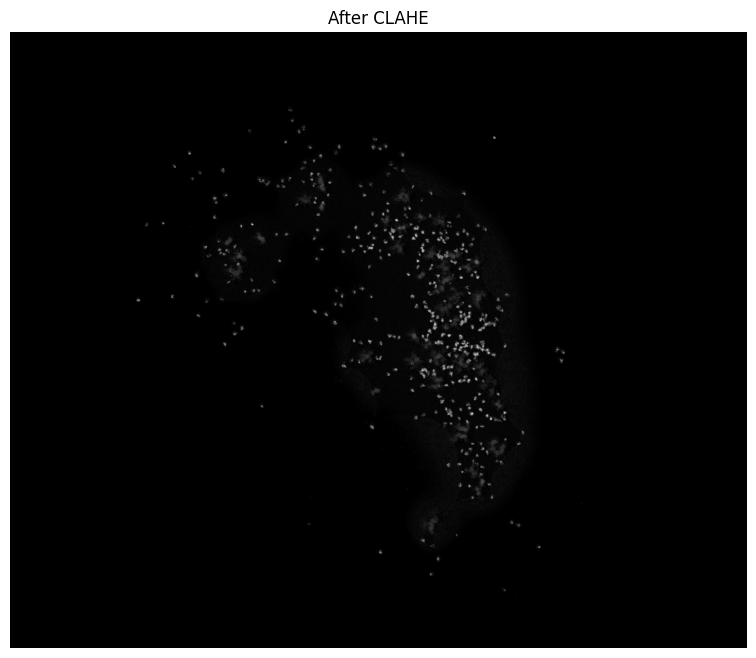

In [14]:
def clahe (gray, clip_limit=1, tile_grid_size=(20, 20)):
    """
    Enhances local contrast using Contrast Limited Adaptive Histogram Equalization (CLAHE).
    
    Parameters:
        gray (numpy.ndarray): Grayscale image.
        clip_limit (float): Threshold for contrast limiting.
        tile_grid_size (tuple): Size of tiles for local equalization.
    
    Returns:
        numpy.ndarray: Contrast-enhanced image.
    
    Explanation:
        - Divides image into tiles, equalizing each histogram with clipping to prevent noise amplification.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)


# Enhancement pipeline step 3
step3 = clahe(step2)


# Visualize enhancement step 3
show_image(step3, 'After CLAHE', cmap='gray', n='3d')


### **4. sig_bin()**

Sigmoid function converts grayscale intensities to a binary-like scale emphasizing bright objects, effectively isolating ecDNAs.

### **Why Sigmoid?**
Converts enhanced grayscale into clearly separated ecDNA and background.

### **Parameters:**

- **`cutoff:`** Threshold for brightness delineation.

- **`gain:`** Steepness of sigmoid function; higher values sharply separate ecDNA pixels from background.

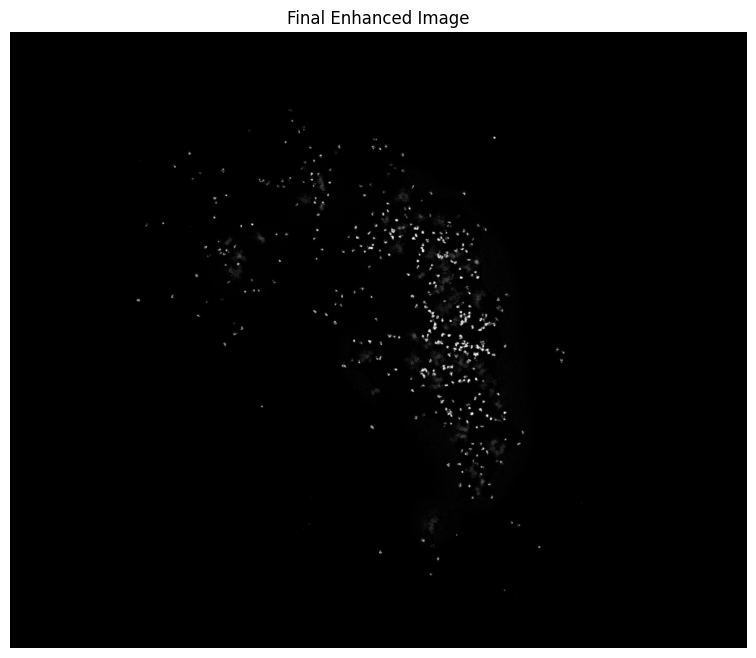

In [16]:
def sig_bin (gray, cutoff=100, gain=10):
    """
    Binarizes ecDNAs using a sigmoid function.

    Parameters:
        gray (numpy.ndarray): Grayscale image.
        cutoff (int): Intensity threshold (0-255).
        gain (float): Sigmoid steepness.
    
    Returns:
        numpy.ndarray: Binarized image.
    
    Explanation:
        - Sigmoid transformation (1/(1+e^(-gain*(x-cutoff))) creates a smooth threshold,
          enhancing ecDNAs above the cutoff.
    """
    # Normalize to 0-1
    norm = gray.astype(np.float32) / 255.0
    cutoff = cutoff / 255.0  # Normalize cutoff
    # Apply sigmoid transformation
    out = 1.0 / (1.0 + np.exp(-gain * (norm - cutoff)))
    # Scale back to 0-255
    sigmoid_img = (out * 255).astype(np.uint8)
    return sigmoid_img

# Enhancement pipeline
step4 = sig_bin(step3)

# Visualize Last enhancement step
show_image(step4, 'Final Enhanced Image', cmap='gray', n='3e')


## Step 3: Object Detection

### Explanation
We detect ecDNAs as connected components in the enhanced image, then merge nearby objects to avoid over-segmentation (e.g., fragmented ecDNAs counted separately).

### Logic
- Threshold the enhanced image with Otsu’s method.
- Apply morphological cleaning to remove noise.
- Detect objects with connected components, filtering by size.
- Merge objects closer than 10 pixels (tuned parameter).
- Overlay detections on the grayscale image.
).

### **5. obj_dtc()**

Identifies ecDNA candidate spots via connected component analysis (cv2.connectedComponentsWithStats()).

- **Connected Components:** Groups contiguous pixels above threshold intensity into objects.

- **Filtering by Area:** Removes small noise and large artifacts using min_area and max_area.

In [18]:
def obj_dtc (enhanced_img, min_area=5, max_area=900):
    """
    Detects ecDNAs as connected components in the enhanced image.

    Parameters:
        enhanced_img (numpy.ndarray): Enhanced grayscale image.
        min_area (int): Minimum object area (pixels).
        max_area (int): Maximum object area (pixels).
    
    Returns:
        list: Objects with bounding boxes, centroids, and areas.
    
    Explanation:
        - Otsu’s thresholding optimizes binary separation. Morphological operations reduce noise.
        - Connected components analysis identifies distinct objects, filtered by size.
    """
    # Apply Otsu’s thresholding for binarization
    _, thresh = cv2.threshold(enhanced_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Morphological cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    
    # Detect connected components
    num_labels, _, stats, centroids = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
    objects = []
    for i in range(1, num_labels):  # Skip background (label 0)
        x, y, w, h, area = stats[i]
        if min_area <= area <= max_area:  # Filter by size
            cx, cy = centroids[i]
            objects.append({"bbox": (x, y, w, h), "area": area, "centroid": (cx, cy)})
    
    return objects



### **6. mrg_obj()**

Prevents fragmented detection by merging objects whose centroids are closer than a specified threshold.

- **`Centroids & Bounding Box:`** Uses spatial distances between detected object centroids (center point coordinates) to determine merging.

In [19]:
def mrg_obj(objects, merge_distance=10):
    """
    Merges nearby objects to avoid over-counting fragmented ecDNAs.
    
    Parameters:
        objects (list): Detected objects.
        merge_distance (float): Maximum centroid distance for merging (pixels).
    
    Returns:
        list: Merged objects.
    
    Explanation:
        - Iteratively merges objects based on Euclidean distance, averaging centroids and expanding boxes.
    """
    merged_objects = []
    used = [False] * len(objects)
    for i in range(len(objects)):
        if used[i]:
            continue
        current = objects[i].copy()
        for j in range(i + 1, len(objects)):
            if used[j]:
                continue
            # Compute Euclidean distance between centroids
            dist = math.dist(current["centroid"], objects[j]["centroid"])
            if dist < merge_distance:
                # Update bounding box to encompass both objects
                x1, y1, w1, h1 = current["bbox"]
                x2, y2, w2, h2 = objects[j]["bbox"]
                new_x = min(x1, x2)
                new_y = min(y1, y2)
                new_w = max(x1 + w1, x2 + w2) - new_x
                new_h = max(y1 + h1, y2 + h2) - new_y
                # Average centroids
                cx1, cy1 = current["centroid"]
                cx2, cy2 = objects[j]["centroid"]
                new_cx = (cx1 + cx2) / 2.0
                new_cy = (cy1 + cy2) / 2.0
                current["bbox"] = (new_x, new_y, new_w, new_h)
                current["centroid"] = (new_cx, new_cy)
                current["area"] += objects[j]["area"]
                used[j] = True
        merged_objects.append(current)
        used[i] = True
    return merged_objects



## Step 4: Classification

### Explanation
Detected objects are classified as ecDNAs or chromosomes using RGB color information. Chromosomes appear white (high value, low saturation in HSV), while ecDNAs are colorful (e.g., red, green from probes).

### Logic
- Overlay objects on the masked RGB image.
- Convert ROI to HSV and classify based on saturation (S) and value (V).
- Annotate with bounding boxes and markers (green for ecDNA, white for chromosomes).
).

### **7. classify_as_white_or_ecDNA**

Differentiates chromosomes (white) from ecDNAs (colorful) by analyzing ROI pixel saturation and brightness in HSV color space.

- **`HSV Color Space:`** Separates color into Hue (color type), Saturation (intensity of color), and Value (brightness).

Chromosomes are characterized by high brightness (Value) but low color intensity (Saturation). Thus, ecDNAs (colorful probes) have higher saturation and varied hues.

In [21]:
def chrom_dtc(roi):
    """
    Classifies objects as ecDNAs or chromosomes based on HSV color.
    
    Logic:
        - ecDNAs are colored (high saturation), chromosomes are white (low saturation, high value).
    
    Parameters:
        roi (numpy.ndarray): Region of interest in BGR.
    
    Returns:
        str: 'ecDNA' or 'chromosome'.
    
    Explanation:
        - HSV space (Hue, Saturation, Value) separates color (H), intensity (V), and purity (S).
        - White regions have high V (>148) and low S (<75), distinguishing chromosomes.
    """
    # Convert to HSV color space
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    # Compute mean saturation (S) and value (V)
    _, s_mean, v_mean, _ = cv2.mean(hsv_roi)
    # White: high brightness (V), low saturation (S)
    if v_mean > 150 and s_mean < 45:
        return "chromosome"
    return "ecDNA"


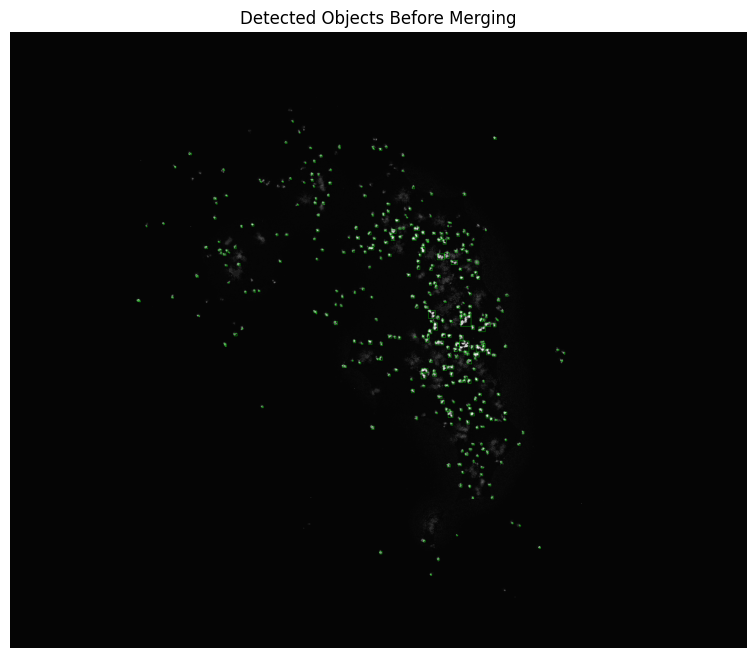

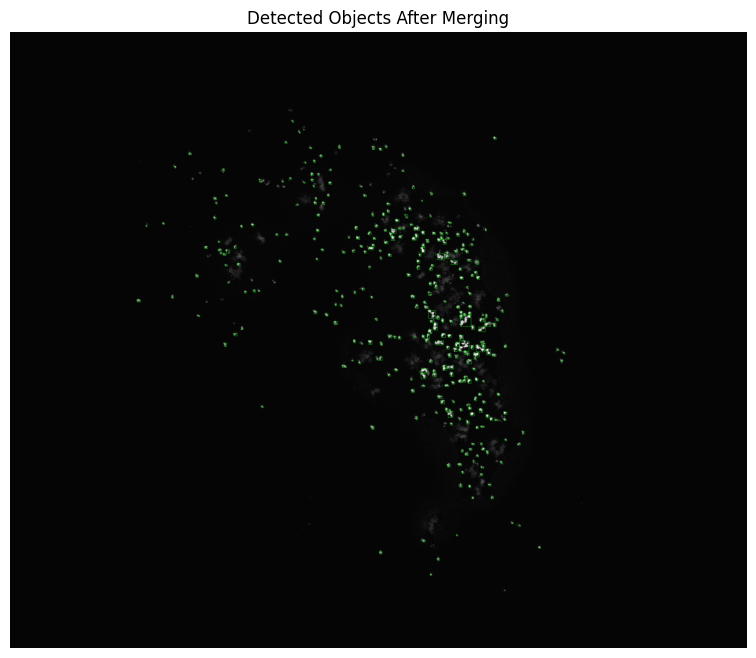

In [23]:
# Detect objects
objects = obj_dtc(step4)

# Visualize before merging
overlay_before = cv2.cvtColor(step4, cv2.COLOR_GRAY2BGR)
for obj in objects:
    x, y, w, h = obj["bbox"]
    cv2.rectangle(overlay_before, (x, y), (x + w, y + h), (0, 255, 0), 1)  # Green bounding box
show_image(overlay_before, 'Detected Objects Before Merging', n='4a')

# Merge close objects
merged_objects = mrg_obj(objects)

# Visualize after merging
overlay_after = cv2.cvtColor(step4, cv2.COLOR_GRAY2BGR)
for obj in merged_objects:
    x, y, w, h = obj["bbox"]
    roi = masked_rgb[y:y+h, x:x+w]  # Extract ROI from RGB image
    label = chrom_dtc(roi)  # Classify once
    obj["label"] = label  # Store the label in the object dictionary
    cv2.rectangle(overlay_after, (x, y), (x + w, y + h), (0, 255, 0), 1)  # Green bounding box
show_image(overlay_after, 'Detected Objects After Merging', n='4b')

Objects are detected using connected components, filtered by size, and merged based on centroid distance. The visualization confirms accurate ecDNA segmentation.

### **8. annotate_and_count**

Annotates identified ecDNAs and chromosomes with bounding boxes, centroid markers, and counts.

- **`Annotations:`** Visual validation ensuring manual inspection aligns with computational classification.

- **`Bounding Boxes & Centroids:`** Bounding boxes outline detected objects; centroids mark precise object locations.

In [24]:
def annotate_cnt (merged_objects, base_img):
    """
    Annotates and counts ecDNAs vs. chromosomes.

    Parameters:
        merged_objects (list): Objects with bbox, centroid, area.
        base_img (numpy.ndarray): Base image for annotation.
    
    Returns:
        tuple: Annotated image, counts dictionary.
    
    Explanation:
        - Uses green for ecDNAs, white for chromosomes; adds centroids and corner markers.
    """
    annotated_img = base_img.copy()
    counts = {"ecDNA": 0, "chromosome": 0}
    marker_size = 6  # Size of the top-left corner marker
    
    for obj in merged_objects:
        # Use stored label
        label = obj["label"]
        counts[label] += 1
        
        # Set color: green for ecDNA, white for chromosomes
        color = (0, 255, 0) if label == "ecDNA" else (255, 255, 255)
        
        # Draw bounding box
        x, y, w, h = obj["bbox"]
        cv2.rectangle(annotated_img, (x, y), (x + w, y + h), color, 1)
        
        # Draw centroid
        cx, cy = obj["centroid"]
        cv2.circle(annotated_img, (int(cx), int(cy)), 2, (0, 0, 255), -1)
        
        # Add text label for chromosomes
        if label == "chromosome":
            cv2.putText(annotated_img, "chromosome", (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        
        # Draw marker in top-left corner
        for mx in range(x, x + marker_size):
            for my in range(y, y + marker_size):
                if mx < annotated_img.shape[1] and my < annotated_img.shape[0]:
                    annotated_img[my, mx] = color
    
    return annotated_img, counts



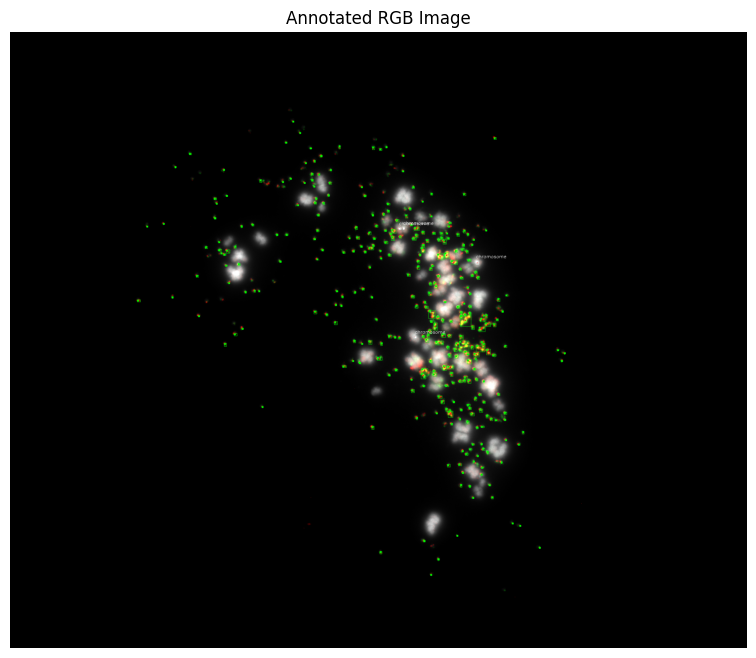

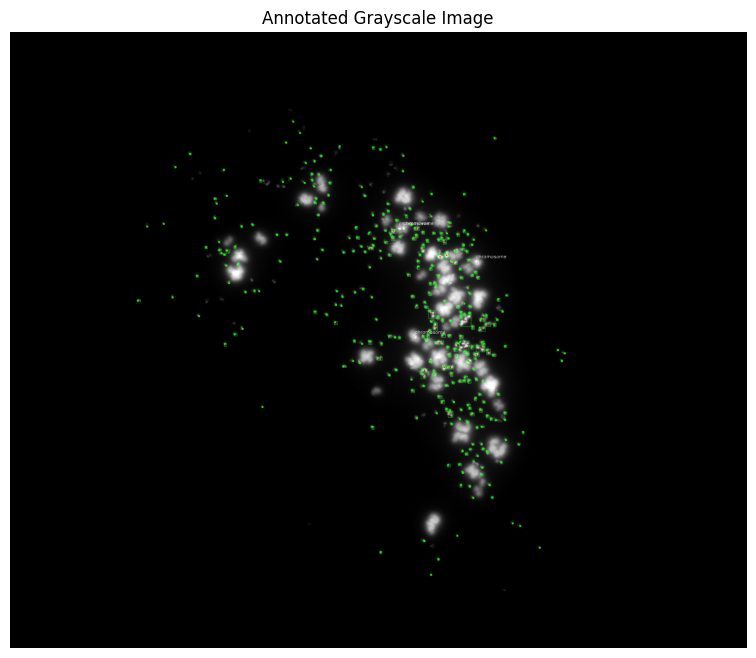

Counts: ecDNAs = 316, Chromosomes = 4


In [25]:
# Classify and count
# Annotate the RGB image
annotated_rgb, counts = annotate_cnt(merged_objects, masked_rgb)

# Convert grayscale image to BGR and annotate it
# Replace 'enhanced_gray' with your grayscale image variable (e.g., 'dapi_img')
annotated_gray = cv2.cvtColor(simple_gray, cv2.COLOR_GRAY2BGR)
annotated_gray, _ = annotate_cnt(merged_objects, annotated_gray)

# Visualize both images
show_image(annotated_rgb, 'Annotated RGB Image', n='5a')
show_image(annotated_gray, 'Annotated Grayscale Image', n='5b')

# Report counts
print(f"Counts: ecDNAs = {counts['ecDNA']}, Chromosomes = {counts['chromosome']}")

# **Validation and Accuracy Metrics**


## **Comparison with MIA**

The lack of precise ecDNA coordinates in the ground truth data prevent conventional object detection metrics, such as precision, recall, or F1-score, which depend on annotated bounding boxes. To address this, the pipeline’s detections were adopted as a reference standard to assess MIA predictions. This comparative approach defined performance metrics relative to the pipeline’s output, acknowledging its role as an approximation rather than an absolute truth.


In this framework:

- False Positives **(FP)** were defined as ecDNAs detected by MIA but not identified by the pipeline.
- False Negatives **(FN)** were ecDNAs detected by the pipeline but missed by MIA.
- True Positives **(TP)** included two subcategories:
- **Full TP**: MIA detections fully overlapping with pipeline detections `(Intersection over Union, IoU ≥ 0.01)`.
- **Partial TP:** MIA detections with minimal overlap `(IoU ≥ 0.001)` or close proximity `(centroid distance < 30 pixels)` to pipeline detections.

### **compute_iou() & match_objects()**

Validation is performed by comparing the pipeline's detections with MIA predictions, calculating overlaps via Intersection-over-Union (IoU).

#### **Intersection-over-Union (IoU)**

IoU measures the overlap between two bounding boxes:  

$$
\text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}
$$

Low IoU thresholds were deliberately chosen to account for the small size and morphological variability of ecDNAs. High thresholds risked misclassifying ecDNA partial overlaps as false positives or negatives, inflating error rates. This adjustment ensured sensitivity to subtle positional differences, reducing “falsy” FP and FN counts.

Qualitative analysis revealed distinct strengths and weaknesses. MIA excelled at detecting ecDNAs with lower intensities or those distant from chromosomes and nuclear centers—regions where probe signals might be faint or absent. Reviewing DAPI and RGB images confirmed that many MIA-predicted FP (missed by the pipeline) were genuine ecDNAs, often lacking strong probe labeling. Conversely, the pipeline outperformed MIA in detecting ecDNAs near chromosomes, where overlapping signals and high background intensity challenged MIA’s segmentation. These complementary capabilities suggest potential for integrating both approaches to enhance overall accuracy.


In [26]:
def mia_dtc (mia_img, min_area=1, max_area=500):
    """
    Segment the MIA predicted mask into individual objects.
    
    Parameters:
        mia_img (numpy.ndarray): Grayscale MIA mask image.
        min_area (int): Minimum area for an object to be considered valid.
        max_area (int): Maximum area for an object to be considered valid.
    
    Returns:
        list: List of dictionaries containing bbox, area, and centroid for each object.
    """
    # Create an elliptical kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # Apply closing to fill small holes in the mask
    mia_filled = cv2.morphologyEx(mia_img, cv2.MORPH_CLOSE, kernel)
    # Detect connected components with statistics (bounding boxes, areas, centroids)
    num_labels, _, stats, centroids = cv2.connectedComponentsWithStats(mia_filled, connectivity=8)
    mia_objects = []
    # Iterate over all components, skipping background (label 0)
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]  # Extract stats: x, y, width, height, area
        # Filter objects by area to remove noise or overly large regions
        if min_area <= area <= max_area:
            cx, cy = centroids[i]  # Centroid coordinates
            # Store object details in a dictionary
            mia_objects.append({"bbox": (x, y, w, h), "area": area, "centroid": (cx, cy)})
    return mia_objects


In [32]:
def compute_iou(bboxA, bboxB):
    """
    Computes Intersection over Union (IoU) for object matching.
    Measures overlap between two bounding boxes as a similarity metric.
    
    Parameters:
        bboxA, bboxB (tuple): Bounding boxes (x, y, w, h).
    
    Returns:
        float: IoU value (0-1).
    
    Explanation:
        - IoU = intersection area / union area, used to assess detection overlap.
    """
    # Calculate intersection rectangle coordinates
    xA = max(bboxA[0], bboxB[0])  # Left edge
    yA = max(bboxA[1], bboxB[1])  # Top edge
    xB = min(bboxA[0] + bboxA[2], bboxB[0] + bboxB[2])  # Right edge
    yB = min(bboxA[1] + bboxA[3], bboxB[1] + bboxB[3])  # Bottom edge
    # Check if there’s no overlap
    if xB < xA or yB < yA:
        return 0.0
    # Compute area of intersection
    interArea = (xB - xA) * (yB - yA)
    # Compute areas of both bounding boxes
    boxAArea = bboxA[2] * bboxA[3]
    boxBArea = bboxB[2] * bboxB[3]
    # Calculate IoU: intersection / (areaA + areaB - intersection)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


In [33]:
def match_obj(ref_objects, mia_objects, iou_full=0.01, iou_partial=0.001, distance_threshold=30.0):
    """
    Match reference ecDNA objects to MIA predicted objects based on IoU and distance.
    
    Parameters:
        ref_objects (list): List of reference ecDNA objects from the pipeline.
        mia_objects (list): List of objects from MIA predictions.
        iou_full (float): IoU threshold for full matches (true positives).
        iou_partial (float): IoU threshold for partial matches.
        distance_threshold (float): Max centroid distance (pixels) for partial matches.
    
    Returns:
        tuple: (full_matches, partial_matches, unmatched_ref, unmatched_mia)
               - full_matches: List of (ref_idx, mia_idx) for full overlaps.
               - partial_matches: List of (ref_idx, mia_idx) for partial overlaps.
               - unmatched_ref: Set of unmatched reference object indices (FN).
               - unmatched_mia: Set of unmatched MIA object indices (FP).
    """
    full_matches = []  # Store indices of full matches
    partial_matches = []  # Store indices of partial matches
    unmatched_ref = set(range(len(ref_objects)))  # Track unmatched reference objects
    unmatched_mia = set(range(len(mia_objects)))  # Track unmatched MIA objects
    
    # Iterate over reference objects
    for i, ref in enumerate(ref_objects):
        # Compare with each unmatched MIA object
        for j, mia in enumerate(mia_objects):
            if j not in unmatched_mia:
                continue  # Skip already matched MIA objects
            iou = compute_iou(ref["bbox"], mia["bbox"])  # Calculate IoU
            # Full match: high IoU indicates strong overlap
            if iou >= iou_full:
                full_matches.append((i, j))
                unmatched_ref.discard(i)
                unmatched_mia.discard(j)
                break  # Move to next reference object
            # Partial match: lower IoU or close centroids
            elif iou >= iou_partial or math.dist(ref["centroid"], mia["centroid"]) < distance_threshold:
                partial_matches.append((i, j))
                unmatched_ref.discard(i)
                unmatched_mia.discard(j)
                break  # Move to next reference object
    return full_matches, partial_matches, unmatched_ref, unmatched_mia



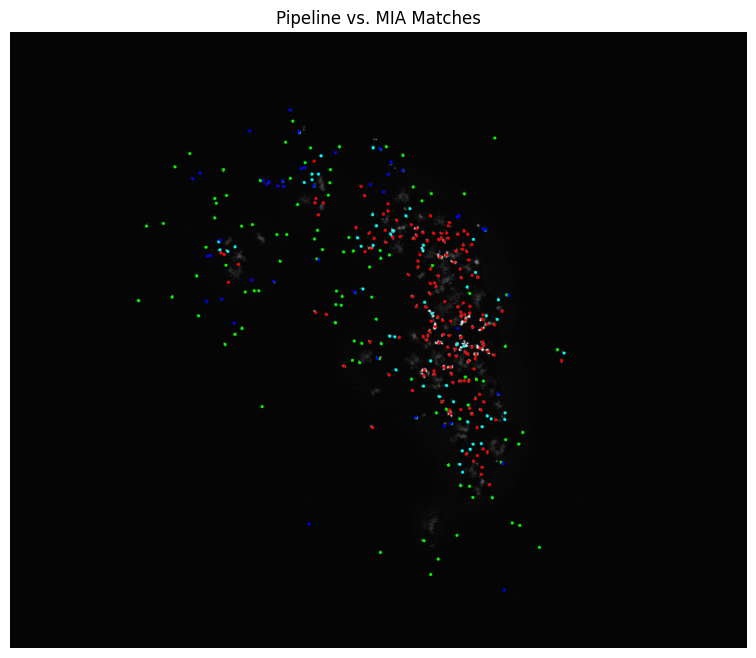

Metrics for MIA, assuming Pipeline result as Ground Truth: TP=99, Partial TP=63, FN=154, FP=45


In [35]:
# Filter merged_objects to include only ecDNAs
ecDNA_objects = [obj for obj in merged_objects if obj["label"] == "ecDNA"]


# Segment MIA and match with adjusted parameters
mia_objects = mia_dtc (mia_img)
full_matches, partial_matches, unmatched_ref, unmatched_mia = match_obj(
    ecDNA_objects, mia_objects, iou_full=0.01, iou_partial=0.001, distance_threshold=30.0
)

# Visualize matches
vis_img = cv2.cvtColor(step4, cv2.COLOR_GRAY2BGR)
for i, j in full_matches:
    cx, cy = ecDNA_objects[i]["centroid"]
    cv2.circle(vis_img, (int(cx), int(cy)), 5, (0, 255, 0), -1)  # Green for TP
for i, j in partial_matches:
    cx, cy = ecDNA_objects[i]["centroid"]
    cv2.circle(vis_img, (int(cx), int(cy)), 5, (255, 255, 0), -1)  # Cyan for partial TP
for i in unmatched_ref:
    cx, cy = ecDNA_objects[i]["centroid"]
    cv2.circle(vis_img, (int(cx), int(cy)), 5, (0, 0, 255), -1)  # Red for FN
for j in unmatched_mia:
    cx, cy = mia_objects[j]["centroid"]
    cv2.circle(vis_img, (int(cx), int(cy)), 5, (255, 0, 0), -1)  # Blue for FP
show_image(vis_img, 'Pipeline vs. MIA Matches', n='6')

# Compute metrics
TP = len(full_matches)
TP_partial = len(partial_matches)
FN = len(unmatched_ref)
FP = len(unmatched_mia)
print(f"Metrics for MIA, assuming Pipeline result as Ground Truth: TP={TP}, Partial TP={TP_partial}, FN={FN}, FP={FP}")

### **Pipeline Parameters and Their Effects Explanations:**

#### **1. top_hat_enhancement:**
   - **`kernel_size (20):`** Size of structuring element for ecDNA isolation. Increase to detect larger ecDNAs; decrease for smaller ones.
   - **`chrom_kernel_size (200):`** Size for chromosome estimation. Larger values suppress bigger structures; too small risks ecDNA suppression.
   - **`dampening_factor (0.6):`** Reduces chromosome intensity (0-1). Lower values darken chromosomes more; higher values preserve nearby ecDNAs.

#### **2. apply_sharpening_gray:**
   - **`strength (8.0):`** Edge enhancement intensity. Higher values sharpen more but amplify noise; lower values soften edges.

#### **3. custom_clahe:**
   - **`clip_limit (1.0):`** Contrast limit. Higher values increase contrast but risk noise; lower values reduce enhancement.
   - **`tile_grid_size ((16, 16)):`** Local equalization grid. Smaller tiles enhance finer details; larger tiles smooth results.

#### **4. apply_sigmoid:**
   - **`cutoff (90):`** Intensity threshold (0-255). Higher values binarize brighter spots; lower values include dimmer ones.
   - **`gain (38.0):`** Sigmoid steepness. Higher values sharpen transitions; lower values create gradual changes.

#### **5. detect_objects:**
   - **`min_area (5):`** Minimum object size (pixels). Increase to filter small noise; decrease to include tiny ecDNAs.
   - **`max_area (500):`** Maximum size. Decrease to exclude large chromosomes; increase for bigger ecDNAs.

#### **6. merge_close_objects:**
   - **`merge_distance (3):`** Merging threshold (pixels). Increase to merge more fragments; decrease for finer separation.

#### **7. classify_as_white_or_ecDNA:**
   - **`v_mean > 148, s_mean < 75:`** HSV thresholds. Adjust V (value) and S (saturation) based on probe brightness/saturation.

#### **8. match_objects:**
   - **`iou_full (0.01):`** Full match IoU. Increase for stricter overlap; decrease for leniency.
   - **`iou_partial (0.001):`** Partial match IoU. Lower values allow minimal overlap; higher values require more.
   - **`distance_threshold (30.0):`** Centroid distance (pixels). Increase to match farther objects; decrease for precision.
---



## OpenCV and Parameter Technical Details

- **`cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))`**  
  Creates an elliptical kernel for morphological operations. Ellipses approximate ecDNA shapes better than rectangles.

- **`cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)`**  
  Removes small bright spots (noise) by erosion followed by dilation.

- **`cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)`**  
  Fills small dark gaps by dilation followed by erosion.

- **`cv2.THRESH_OTSU`**  
  Automatically selects an optimal threshold by maximizing inter-class variance.

- **`cv2.createCLAHE`**  
  Initializes CLAHE for local contrast enhancement.

- **`num_labels, _, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)`**  
  Labels connected regions, providing bounding boxes (`stats`) and centroids (pixel-weighted centers).

- **`cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness)`**  
  Adds text labels (e.g., "chromosome") with specified font and style.

---

### HSV Color Space

- **Hue (H)**  
  Color type (0–179 in OpenCV). Irrelevant here as we focus on saturation and value.

- **Saturation (S)**  
  Color purity (0–255). Low S indicates white/gray; high S indicates vivid colors (ecDNAs).

- **Value (V)**  
  Brightness (0–255). High V with low S denotes white chromosomes.

---

### Bounding Boxes and Centroids

- **Bounding Box**  
  Rectangle `(x, y, width, height)` enclosing an object.

- **Centroid**  
  Center of mass `(cx, cy)` of a connected component, used for merging and matching.

---


## Conclusion
This tutorial demonstrated the ecDNA counting pipeline on a sample image, from preprocessing to validation. The pipeline enhances ecDNA visibility, detects spots, and classifies them using color, improving over MIA’s limitations. For full dataset processing, see the batch-processing notebook.


## Acknowledgment

**Use of AI-Based Code Generation and Editing Tools**  
This project was enhanced by the use of AI tools—ChatGPT, Grok, and Copilot—which played significant roles in improving the code, explanations, and overall presentation of the work.

### Specific Contributions

- **ChatGPT**:
  - Added comments to various functions to improve code readability and understanding.
  - Assisted in optimizing functions and replacing less effective ones, leading to better performance and results.
  - Proposed the enhancement process, including the use of object detection methods instead of overlapping pixels, which improved the accuracy and efficiency of the pipeline.
  - Provided clear, simplified explanations of complex concepts to make the content more accessible.
  - Edited text for grammatical accuracy, clarity, and an appropriate tone.

- **Grok**:
  - Contributed to adding comments to functions for better documentation.
  - Helped optimize functions and suggested replacements that improved the project’s outcomes.
  - Assisted in refining explanations to ensure they were concise and easy to understand.


All three tools—ChatGPT, Grok, and Copilot—were used to simplify explanations, making them clearer and more accessible. They also assisted in editing the grammar and tone of the text to improve readability and professionalism.

- **Iterative Refinement Process:**
For most parts of this project, I provided the same prompts to ChatGPT, Grok, and Copilot to compare their responses. I then asked each tool to evaluate the outputs of the others and provide feedback. This feedback was shared back with the tools, allowing them to refine their suggestions iteratively. This process ensured that the final code, explanations, and results were optimized for accuracy, clarity, and effectiveness.

### Citations

- OpenAI. (2023). ChatGPT (Version o3-mini-high for code and logics & Version 4.5 for text editing) Large language model. https://openai.com/chatgpt
- Grok (2023). xAI.(Version 3.0). Used for text generation and code refinement in this project. https://xai.com/grok
- Microsoft Copilot (an AI assistant developed by Microsoft),



